In [1]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import metpy
import scipy.stats as sts
import re
from glob import glob
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.convection import dry_profile_temp, potential_temp
from isca_tools.convection.base import convection_neutral_profile
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig, label_subplots
from isca_tools.thesis.adiabat_theory2 import get_cape_approx
from isca_tools.thesis.lapse_integral import integral_and_error_calc
from isca_tools.thesis.lapse_integral_simple import get_temp_2_layer_approx, get_lnb_ind
from isca_tools.thesis.lapse_theory import get_var_at_plev
from isca_tools.thesis.mod_parcel_theory import get_scale_factor_theory_numerical, get_temp_mod_parcel
from isca_tools.utils.base import weighted_RMS, insert_to_array
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
from isca_tools.convection.base import lcl_metpy, lapse_moist, moist_profile, lcl_sigma_bolton_simple
from isca_tools.thesis.profile_fitting import get_mse_env, get_tropopause_lev_ind, get_mse_prof_rms
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
from typing import Tuple, Optional
import os
from sklearn.decomposition import PCA

from isca_tools.utils.xarray import wrap_with_apply_ufunc

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Formatting figures info
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']
leg_handlelength = 1.5

## Load Data
Once compute the parcel temperature at $p_{FT}$, I save the dataset as takes around 8 minutes to compute.

In [8]:
path_processed = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/theory_lapse/cesm/thesis_figs/ds_processed'
ds = {surf: xr.load_dataset(os.path.join(path_processed, f"ds_tropics_{surf}.nc")) for surf in ['ocean', 'land']}

## Which $p_{FT}$ to choose
Here, 400hPa is better because more *convective* days according to error thresholding, and helps with topography issues i.e. more
regions have at least 100hPa from LCL to FT level.

In [9]:
def get_valid_mask(ds, error_thresh=0.25, aloft_p_size_thresh=None):
    # Take average over all days for which error satisfies convective threshold
    const1_error = np.abs(ds.const1_error.sum(dim='layer') / ds.const1_integral.sum(dim='layer'))
    mod_parcel1_error = np.abs(ds.mod_parcel1_error.sum(dim='layer') / ds.mod_parcel1_integral.sum(dim='layer'))

    mask_fit = (mod_parcel1_error < const1_error) & (mod_parcel1_error < error_thresh)
    if aloft_p_size_thresh is not None:
        p_lcl = lcl_sigma_bolton_simple(ds.rh_REFHT, ds.temp_surf_lcl_calc) * ds.PS
        mask_fit = mask_fit & (p_lcl - ds.p_ft > aloft_p_size_thresh)
    return mask_fit

In [10]:
aloft_p_size_thresh = 100*100    # Need at least 100hPa between LCL and FT level
for key in ds:
    n_days = ds[key].quant.size * ds[key].lat.size * ds[key].lon_sample.size
    for p_ft in ds[key].p_ft:
        var1 = get_valid_mask(ds[key].sel(p_ft=p_ft)).sum(dim=['quant', 'lat', 'lon_sample']).values / n_days * 100
        var2 = get_valid_mask(ds[key].sel(p_ft=p_ft), aloft_p_size_thresh=aloft_p_size_thresh
                              ).sum(dim=['quant', 'lat', 'lon_sample']).values / n_days * 100
        print(key, float(p_ft/100), 'No lcl masking', np.round(var1, 1), 'With lcl masking', np.round(var2, 1))

ocean 400.0 No lcl masking [83.7 76.4] With lcl masking [83.7 76.4]
ocean 500.0 No lcl masking [73.7 61.1] With lcl masking [73.7 61.1]
ocean 700.0 No lcl masking [20.2 32.2] With lcl masking [20.2 32.2]
land 400.0 No lcl masking [85.9 82.9] With lcl masking [84.6 81.8]
land 500.0 No lcl masking [70.7 61.4] With lcl masking [65.  56.3]
land 700.0 No lcl masking [ 8.  12.8] With lcl masking [5.4 8.7]


### Fitting Error
Below we show that fitting error better for `mod_parcel` for aquaplanet but not land. Also, that `convflag` closer to 2 for aquaplanet indicating deep convection triggered more.

I use median and IQR for shading because `convflag` takes almost discrete values, so $\pm$ standard deviation shading looks way too big, given
that very few days have `convflag<1`. I.e. $\pm \sigma$ forces symmetric shading, when data is not symmetric about median.

In [11]:
p_ft_use = 400 * 100
for key in ds:
    ds[key] = ds[key].sel(p_ft=p_ft_use)

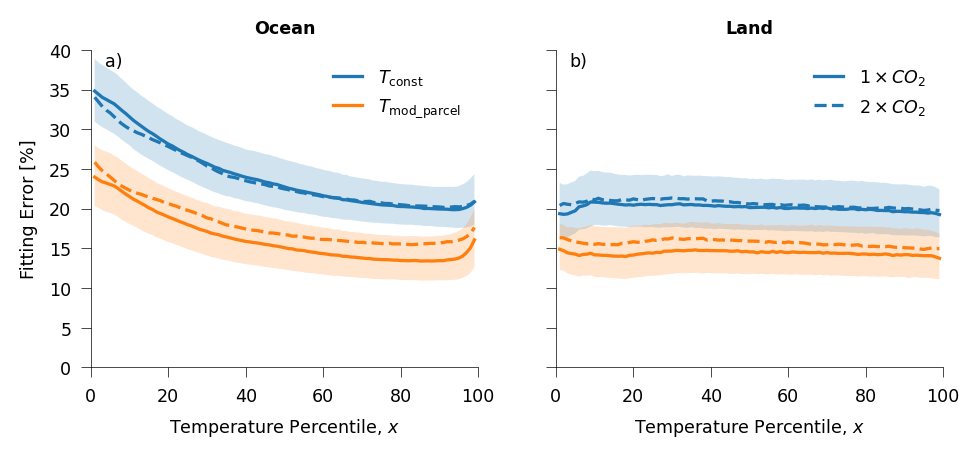

In [15]:
# lat_weights = np.cos(np.deg2rad(ds['land'].lat))
percentile_label = 'Temperature Percentile, $x$'

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'])
for k, surf_use in enumerate(ds):
    ds_use = ds[surf_use]
    lat_weights = np.cos(np.deg2rad(ds_use.lat))
    ax[k].set_title(surf_use.capitalize(), fontweight='bold')
    ax[k].set_xlabel(percentile_label)
    for j in range(ds['ocean'].co2.size):
        for i, key in enumerate(['const1', 'mod_parcel1']):
            if k == 0:
                label_use = "$T_{\\text{" + key[:-1] + "}}$" if j == 0 else None
            else:
                label_use = f"${ds['ocean'].co2[j]:.0f} \\times CO_2$" if i == 0  else None
            var = np.abs(ds_use[f"{key}_error"].sum(dim='layer') / ds_use[f"{key}_integral"].sum(dim='layer') * 100,).isel(co2=j)
            ax[k].plot(ds_use.quant, np.average(var.quantile(0.5, dim='lon_sample'), axis=1, weights=lat_weights), color=f"C{i}",
                          linestyle=[None, '--'][j], label=label_use)
            if j == 0:
                ax[k].fill_between(ds_use.quant, np.average(var.quantile(0.25, dim='lon_sample'), axis=1, weights=lat_weights),
                                      np.average(var.quantile(0.75, dim='lon_sample'), axis=1, weights=lat_weights), alpha=0.2,
                                      color=f"C{i}", edgecolor="none")

update_linewidth(fig, 1.5)
ax[0].set_ylim(0, 40)
ax[0].set_xlim(0, 100)
ax[0].set_ylabel('Fitting Error [%]')
ax[0].legend(handlelength=leg_handlelength)
ax[1].legend(handlelength=leg_handlelength)
label_subplots(fig, ax.flatten(), pos_y=-1, box_alpha=0)
update_fontsize(fig)
plt.show()
# isca_tools.savefig(fig)

### Valid days
Below I plot for the aquaplanet simulation, the days for which `mod_parcel` has lower error than 25% and thus days valid to consider convctive.

For land, very few days are valid so no point proceeding.

[66.33859752 80.02046347]
0.0


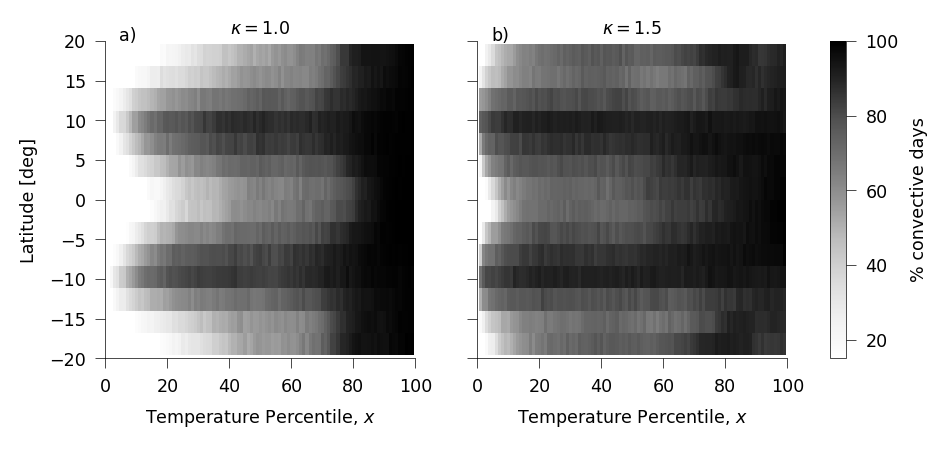

In [113]:
surf_plot = 'aquaplanet'
error_thresh = 0.25
# error_thresh2 = 0.1
const1_error = np.abs(ds[surf_plot].const1_error.sum(dim='layer') / ds[surf_plot].const1_integral.sum(dim='layer'))
mod_parcel1_error = np.abs(
    ds[surf_plot].modParc1_error.sum(dim='layer') / ds[surf_plot].modParc1_integral.sum(dim='layer'))
mask_fit = (mod_parcel1_error < const1_error) & (mod_parcel1_error < error_thresh) & (ds[surf_plot].p_lzb/100 < 500)

# Print total number of days valid
print((mask_fit.sum(dim=['sample', 'quant', 'lat']).values / (mask_fit.sample.size*mask_fit.quant.size*mask_fit.lat.size))*100)

var = (mask_fit.sum(dim='sample') / mask_fit.sample.size * 100)
print(var.values.min())

fig, ax = plt.subplots(1, ds['aquaplanet'].tau_lw.size, sharey=True, sharex=True)
fig_resize(fig, width['two_col'])
for i in range(ds['aquaplanet'].tau_lw.size):
    im = var.T.isel(tau_lw=i).plot.imshow(ax=ax[i], cmap='Grays', vmin=15, vmax=100, add_colorbar=False)
    ax[i].set_xlabel(percentile_label)
    ax[i].set_title(f"$\kappa={var.tau_lw[i]:.1f}$", y=0.97)
ax[0].set_ylim(-20, 20)
ax[0].set_xlim(0, 100)
ax[0].set_ylabel('Latitude [deg]')
ax[1].set_ylabel('')
fig.colorbar(im, ax=ax, label='% convective days')
label_subplots(fig, ax, box_alpha=0, pos_y=5)
update_fontsize(fig, 10)
plt.show()
# isca_tools.savefig(fig)